In [1]:
import os
import re
import json
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import torch
import tifffile
from einops import rearrange, repeat

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.multiplex as multiplex
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
from mushroom.mushroom import Mushroom

In [6]:
project_dir = '/data/estorrs/mushroom/data/projects/submission_v1'
output_dir = os.path.join(project_dir, 'analysis', 'export')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [7]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [8]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [9]:
# exclude = ['S18-25943-A7', 'C3L-00970', 'WD-76845']

In [10]:
fps = sorted(utils.listfiles(project_dir, regex=r'mushroom_25res/config.yaml$'))
fps

['/data/estorrs/mushroom/data/projects/submission_v1/C3L-00970/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-00982/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-01287/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/C3L-02551/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT225C1/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT268B1/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT339B2-H1/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT397B1/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-K2/mushroom_25res/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/HT413C1-Th1k4A1/mushroom_25res/co

In [11]:
case_to_sections = {fp.split('/')[-3]:yaml.safe_load(open(fp))['sections'] for fp in fps}
# case_to_sections = {k:v for k, v in case_to_sections.items() if k not in exclude}
case_to_sections.keys()

dict_keys(['C3L-00970', 'C3L-00982', 'C3L-01287', 'C3L-02551', 'HT206B1', 'HT225C1', 'HT268B1', 'HT339B2-H1', 'HT397B1', 'HT413C1-K2', 'HT413C1-Th1k4A1', 'HT448C1-Th1K1Fp1', 'HT553P1-H2', 'HT565B1-H2', 'S18-25943-A7', 'S18-5591-C8', 'S18-9906', 'P21_F2RM6R'])

In [12]:
case = 'HT206B1'

In [13]:
sections = case_to_sections[case]
sections

[{'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s0_HT206B1-U1_xenium.h5ad'}],
  'position': 0,
  'sid': 'HT206B1-U1'},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s1_HT206B1-U2_multiplex.ome.tiff'}],
  'position': 5,
  'sid': 'HT206B1-U2'},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s2_HT206B1-U4_he.tif'}],
  'position': 15,
  'sid': 'HT206B1-U4'},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s3_HT206B1-U5_multiplex.ome.tiff'}],
  'position': 20,
  'sid': 'HT206B1-U5'},
 {'data': [{'dtype': 'xenium',
    'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s4_HT206B1-U8_xenium.h5ad'}],
  'position': 40,
  'sid': 'HT206B1-U8'},
 {'data': [{'dtype': 'xenium',
    'filep

In [15]:
dtype_to_volume = pickle.load(
    open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
)['labeled']

outputs = pickle.load(
    open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
)
section_ids = outputs['section_ids']
section_positions = outputs['section_positions']
section_ids, section_positions

([('HT206B1-U1', 'xenium'),
  ('HT206B1-U2', 'multiplex'),
  ('HT206B1-U4', 'he'),
  ('HT206B1-U5', 'multiplex'),
  ('HT206B1-U8', 'xenium'),
  ('HT206B1-U9', 'xenium'),
  ('HT206B1-U10', 'multiplex'),
  ('HT206B1-U12', 'he'),
  ('HT206B1-U13', 'multiplex'),
  ('HT206B1-U16', 'xenium'),
  ('HT206B1-U17', 'xenium'),
  ('HT206B1-U18', 'multiplex'),
  ('HT206B1-U20', 'he'),
  ('HT206B1-U21', 'multiplex'),
  ('HT206B1-U24', 'xenium')],
 array([ 0,  1,  3,  4,  8,  9, 10, 12, 13, 16, 17, 18, 20, 21, 24]))

In [16]:
mushroom = Mushroom.from_config(
    os.path.join(project_dir, case, 'mushroom_50res'), accelerator='cpu'
)

INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:3 sections detected: ['HT206B1-U4', 'HT206B1-U12', 'HT206B1-U20']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U4


0.02


INFO:root:generating image data for section HT206B1-U12
INFO:root:generating image data for section HT206B1-U20
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 3 sections detected: [('HT206B1-U4', 'he'), ('HT206B1-U12', 'he'), ('HT206B1-U20', 'he')]
INFO:root:creating data loaders
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmp8p6k40b9
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmp8p6k40b9/_remote_module_non_scriptable.py
INFO:root:creating ViT
INFO:root:model initialized


he torch.Size([3, 130, 121])


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/he_chkpts/last-v2.ckpt
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 36 channels
INFO:root:6 sections detected: ['HT206B1-U2', 'HT206B1-U5', 'HT206B1-U10', 'HT206B1-U13', 'HT206B1-U18', 'HT206B1-U21']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U2


0.02


INFO:root:generating image data for section HT206B1-U5
INFO:root:generating image data for section HT206B1-U10
INFO:root:generating image data for section HT206B1-U13
INFO:root:generating image data for section HT206B1-U18
INFO:root:generating image data for section HT206B1-U21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('HT206B1-U2', 'multiplex'), ('HT206B1-U5', 'multiplex'), ('HT206B1-U10', 'multiplex'), ('HT206B1-U13', 'multiplex'), ('HT206B1-U18', 'multiplex'), ('HT206B1-U21', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

multiplex torch.Size([36, 130, 121])


INFO:root:using 377 channels
INFO:root:6 sections detected: ['HT206B1-U1', 'HT206B1-U8', 'HT206B1-U9', 'HT206B1-U16', 'HT206B1-U17', 'HT206B1-U24']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U1
INFO:root:generating image data for section HT206B1-U8
INFO:root:generating image data for section HT206B1-U9
INFO:root:generating image data for section HT206B1-U16
INFO:root:generating image data for section HT206B1-U17
INFO:root:generating image data for section HT206B1-U24


xenium torch.Size([377, 131, 122])


INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('HT206B1-U1', 'xenium'), ('HT206B1-U8', 'xenium'), ('HT206B1-U9', 'xenium'), ('HT206B1-U16', 'xenium'), ('HT206B1-U17', 'xenium'), ('HT206B1-U24', 'xenium')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:root:loading checkpoint: /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_50res/xenium_chkpts/last-v2.ckpt
INFO:root:chkpt files detected, embedding to spores
INFO:root:embedding he spore
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch

Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore


Predicting: |                                                                                                 …

In [17]:
outputs = pickle.load(
    open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
)
outputs.keys()

dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities', 'dtype_to_cluster_to_agg'])

In [18]:
dtype = 'xenium'
spore = mushroom.dtype_to_spore[dtype]
combined = None
for sid, a in spore.learner_data.dtype_to_section_to_adata[dtype].items():
    for level in range(mushroom.num_levels):
        pts = a.obsm['spatial']
        labels = mushroom.assign_pts(pts, (sid, dtype), dtype, level=level)
        a.obs[f'nbhd_{dtype}_level{level}'] = [f'nbhd {x}' for x in labels]
        
        dtype_to_volume = pickle.load(
            open(os.path.join(project_dir, case, 'mushroom_25res', f'nbhd_volumes_l{level}.pkl'), 'rb')
        )['labeled']
        
        labels = mushroom.assign_pts(pts, (sid, dtype), dtype, level=level, use_volume=True, volume=dtype_to_volume['integrated'])
        a.obs[f'nbhd_integrated_level{level}'] = [f'nbhd {x}' for x in labels]
        
        labels = mushroom.assign_pts(pts, (sid, dtype), dtype, level=level, use_volume=True, volume=dtype_to_volume['multiplex'])
        a.obs[f'nbhd_multiplex_level{level}'] = [f'nbhd {x}' for x in labels]
    df = a.obs[[x for x in a.obs.columns if 'nbhd' in x]]
    df['sid'] = sid
    df.index = [f'{sid}-{x}' for x in df.index.to_list()]
    
    if combined is None:
        combined = df
    else:
        combined = pd.concat((combined, df))
combined
        

/tmp/ipykernel_1165182/2250139842.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs[f'nbhd_{dtype}_level{level}'] = [f'nbhd {x}' for x in labels]
/tmp/ipykernel_1165182/2250139842.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sid'] = sid
/tmp/ipykernel_1165182/2250139842.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a.obs[f'nbhd_{dtype}_level{level}'] = [f'nbhd {x}' for x in labels]
/tmp/ipykernel_1165182/2250139842.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

,nbhd_xenium_level0,nbhd_integrated_level0,nbhd_multiplex_level0,nbhd_xenium_level1,nbhd_integrated_level1,nbhd_multiplex_level1,nbhd_xenium_level2,nbhd_integrated_level2,nbhd_multiplex_level2,sid
HT206B1-U1-aaaaeefm-1,nbhd 4,nbhd 9,nbhd 4,nbhd 14,nbhd 13,nbhd 16,nbhd 22,nbhd 20,nbhd 29,HT206B1-U1
HT206B1-U1-aaaagokl-1,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,HT206B1-U1
HT206B1-U1-aaaaippd-1,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,HT206B1-U1
HT206B1-U1-aaaajeja-1,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,HT206B1-U1
HT206B1-U1-aaablpen-1,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,HT206B1-U1
...,...,...,...,...,...,...,...,...,...,...
HT206B1-U24-oilkdgen-1,nbhd 5,nbhd 2,nbhd 4,nbhd 15,nbhd 13,nbhd 13,nbhd 25,nbhd 20,nbhd 23,HT206B1-U24
HT206B1-U24-oilkljhi-1,nbhd 5,nbhd 2,nbhd 4,nbhd 15,nbhd 13,nbhd 13,nbhd 25,nbhd 20,nbhd 23,HT206B1-U24
HT206B1-U24-oilkmkbb-1,nbhd 5,nbhd 2,nbhd 4,nbhd 15,nbhd 13,nbhd 13,nbhd 25,nbhd 20,nbhd 23,HT206B1-U24
HT206B1-U24-oilkmpah-1,nbhd 5,nbhd 2,nbhd 4,nbhd 15,nbhd 13,nbhd 13,nbhd 25,nbhd 20,nbhd 23,HT206B1-U24


In [19]:
combined

,nbhd_xenium_level0,nbhd_integrated_level0,nbhd_multiplex_level0,nbhd_xenium_level1,nbhd_integrated_level1,nbhd_multiplex_level1,nbhd_xenium_level2,nbhd_integrated_level2,nbhd_multiplex_level2,sid
HT206B1-U1-aaaaeefm-1,nbhd 4,nbhd 9,nbhd 4,nbhd 14,nbhd 13,nbhd 16,nbhd 22,nbhd 20,nbhd 29,HT206B1-U1
HT206B1-U1-aaaagokl-1,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,HT206B1-U1
HT206B1-U1-aaaaippd-1,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,HT206B1-U1
HT206B1-U1-aaaajeja-1,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,HT206B1-U1
HT206B1-U1-aaablpen-1,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,HT206B1-U1
...,...,...,...,...,...,...,...,...,...,...
HT206B1-U24-oilkdgen-1,nbhd 5,nbhd 2,nbhd 4,nbhd 15,nbhd 13,nbhd 13,nbhd 25,nbhd 20,nbhd 23,HT206B1-U24
HT206B1-U24-oilkljhi-1,nbhd 5,nbhd 2,nbhd 4,nbhd 15,nbhd 13,nbhd 13,nbhd 25,nbhd 20,nbhd 23,HT206B1-U24
HT206B1-U24-oilkmkbb-1,nbhd 5,nbhd 2,nbhd 4,nbhd 15,nbhd 13,nbhd 13,nbhd 25,nbhd 20,nbhd 23,HT206B1-U24
HT206B1-U24-oilkmpah-1,nbhd 5,nbhd 2,nbhd 4,nbhd 15,nbhd 13,nbhd 13,nbhd 25,nbhd 20,nbhd 23,HT206B1-U24


In [23]:
set(combined['sid'])

{'HT206B1-U1',
 'HT206B1-U16',
 'HT206B1-U17',
 'HT206B1-U24',
 'HT206B1-U8',
 'HT206B1-U9'}

In [21]:
meta = pd.read_csv(
    '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/auxiliary/xenium/HT206B1-H2L1Us1_17_cell_type.txt',
    sep='\t', index_col=0
)
meta

,cell_type
aaaaeefm-1,Nothing
aaaagokl-1,Cancer cells
aaaaippd-1,Cancer cells
aaaajeja-1,Cancer cells
aaablpen-1,Cancer cells
...,...
oikcfelo-1,T-cells
oikcgcbk-1,T-cells
oikdmjki-1,Plasma cells
oikecdga-1,T-cells


In [28]:
for sid in set(combined['sid']):
    print(sid)
    df = combined[combined['sid']==sid]
    df.index = ['-'.join(x.split('-')[-2:]) for x in df.index.to_list()]
    df = pd.merge(df, meta, left_index=True, right_index=True)
    print(df.shape)

HT206B1-U9
(3, 11)
HT206B1-U8
(6, 11)
HT206B1-U24
(2, 11)
HT206B1-U1
(115758, 11)
HT206B1-U16
(7, 11)
HT206B1-U17
(1, 11)


In [29]:
df = combined[combined['sid']=='HT206B1-U1']
df.index = ['-'.join(x.split('-')[-2:]) for x in df.index.to_list()]
df = pd.merge(df, meta, left_index=True, right_index=True)
df

,nbhd_xenium_level0,nbhd_integrated_level0,nbhd_multiplex_level0,nbhd_xenium_level1,nbhd_integrated_level1,nbhd_multiplex_level1,nbhd_xenium_level2,nbhd_integrated_level2,nbhd_multiplex_level2,sid,cell_type
aaaaeefm-1,nbhd 4,nbhd 9,nbhd 4,nbhd 14,nbhd 13,nbhd 16,nbhd 22,nbhd 20,nbhd 29,HT206B1-U1,Nothing
aaaagokl-1,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,HT206B1-U1,Cancer cells
aaaaippd-1,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,HT206B1-U1,Cancer cells
aaaajeja-1,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,HT206B1-U1,Cancer cells
aaablpen-1,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,HT206B1-U1,Cancer cells
...,...,...,...,...,...,...,...,...,...,...,...
oikcfelo-1,nbhd 4,nbhd 2,nbhd 4,nbhd 14,nbhd 13,nbhd 13,nbhd 22,nbhd 20,nbhd 23,HT206B1-U1,T-cells
oikcgcbk-1,nbhd 4,nbhd 2,nbhd 4,nbhd 14,nbhd 13,nbhd 13,nbhd 22,nbhd 20,nbhd 23,HT206B1-U1,T-cells
oikdmjki-1,nbhd 4,nbhd 2,nbhd 4,nbhd 14,nbhd 13,nbhd 13,nbhd 22,nbhd 20,nbhd 23,HT206B1-U1,Plasma cells
oikecdga-1,nbhd 4,nbhd 2,nbhd 4,nbhd 14,nbhd 13,nbhd 13,nbhd 22,nbhd 20,nbhd 23,HT206B1-U1,T-cells


In [48]:
source.values.sum(1)

array([1.0000e+00, 1.0000e+00, 5.0600e+02, 2.3000e+01, 3.2000e+01,
       3.0400e+02, 8.7700e+02, 1.0000e+00, 1.5560e+03, 1.3270e+03,
       1.2360e+03, 1.0400e+02, 4.2000e+01, 5.0000e+01, 1.4200e+02,
       1.1450e+03, 5.1710e+04, 1.4180e+03, 2.6630e+03, 5.0817e+04,
       1.6800e+02, 9.8000e+01, 1.0000e+00, 9.5000e+01, 2.9000e+02,
       3.8400e+02, 8.6000e+01, 5.6000e+01, 9.0000e+00, 3.3000e+01,
       3.0000e+00, 8.0000e+00, 3.5000e+02, 1.5000e+02, 7.2000e+01])

In [52]:
source = df.copy()
source = source[['nbhd_xenium_level2', 'cell_type']]
source['value'] = 1
source = pd.pivot_table(source, columns='cell_type', index='nbhd_xenium_level2', values='value', aggfunc='sum')
source[pd.isnull(source)] = 0.
source = source[source.values.sum(1) > 100]
source

cell_type,Adipocytes,B-cells,Cancer cells,Endothelial,Fibroblasts,Macrophages,Mast cells,Myoepitelial/Normal ducts,NK cells,Nothing,Plasma cells,T-cells,mregDC,pDC
nbhd_xenium_level2,,,,,,,,,,,,,,
nbhd 0,0.0,5.0,3.0,50.0,90.0,49.0,4.0,521.0,0.0,1.0,77.0,63.0,0.0,24.0
nbhd 1,1.0,19.0,8.0,54.0,135.0,55.0,14.0,518.0,0.0,0.0,108.0,88.0,0.0,19.0
nbhd 10,0.0,10.0,16.0,60.0,58.0,55.0,6.0,332.0,10.0,8.0,82.0,265.0,6.0,24.0
nbhd 11,40.0,228.0,1129.0,1024.0,658.0,1673.0,53.0,232.0,223.0,350.0,398.0,4175.0,137.0,671.0
nbhd 12,0.0,27.0,13.0,31.0,21.0,54.0,0.0,45.0,19.0,1.0,11.0,394.0,24.0,43.0
nbhd 13,0.0,5.0,1692.0,33.0,36.0,51.0,0.0,5.0,4.0,73.0,2.0,58.0,4.0,10.0
nbhd 14,8.0,9.0,6773.0,129.0,119.0,212.0,1.0,30.0,8.0,404.0,11.0,113.0,7.0,36.0
nbhd 15,2.0,5.0,3081.0,142.0,112.0,197.0,0.0,4.0,16.0,328.0,21.0,211.0,6.0,39.0
nbhd 18,25.0,79.0,840.0,767.0,677.0,799.0,37.0,127.0,77.0,262.0,223.0,1202.0,41.0,160.0


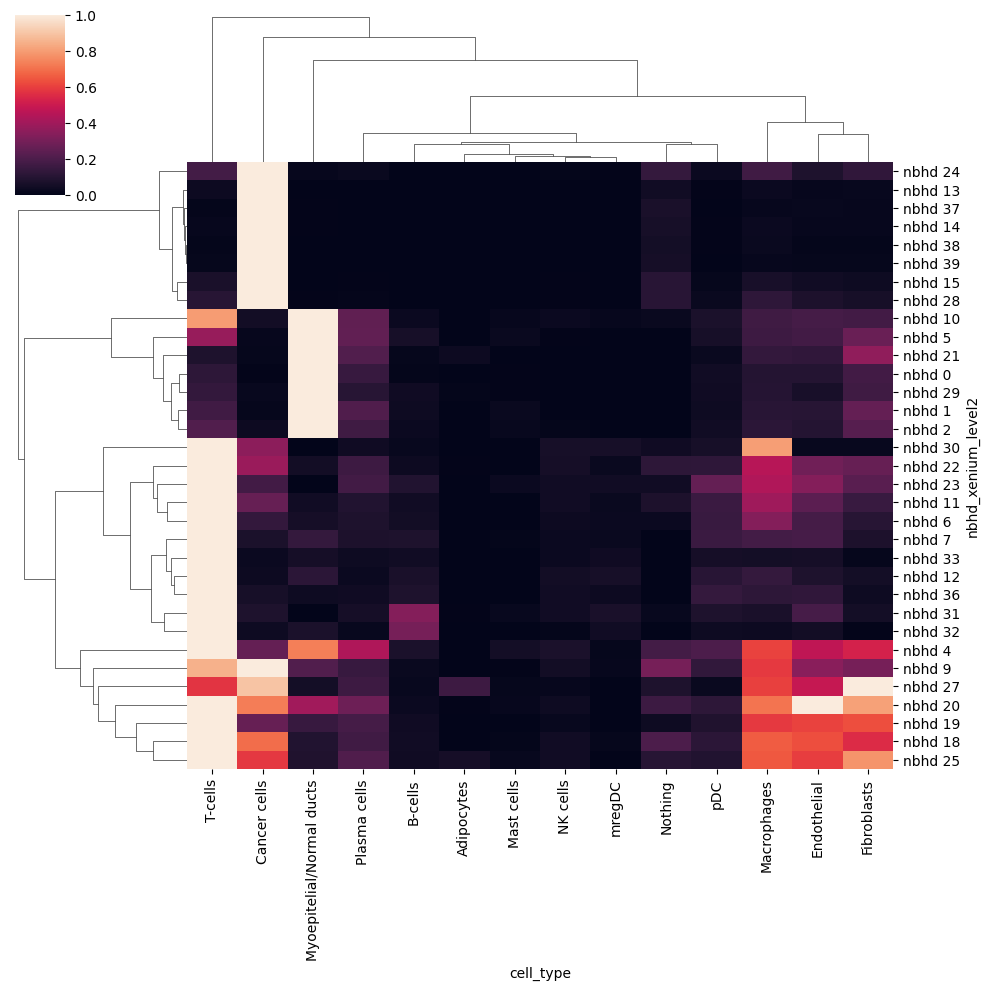

In [53]:
sns.clustermap(source, standard_scale=0)

In [63]:
dtype_to_volume = pickle.load(
    open(os.path.join(project_dir, case, 'mushroom_50res', f'nbhd_volumes_l2.pkl'), 'rb')
)['labeled']

outputs = pickle.load(
    open(os.path.join(project_dir, case, 'mushroom_50res', f'outputs.pkl'), 'rb')
)
section_ids = outputs['section_ids']
section_positions = outputs['section_positions']
section_ids, section_positions

([('HT206B1-U1', 'xenium'),
  ('HT206B1-U2', 'multiplex'),
  ('HT206B1-U4', 'he'),
  ('HT206B1-U5', 'multiplex'),
  ('HT206B1-U8', 'xenium'),
  ('HT206B1-U9', 'xenium'),
  ('HT206B1-U10', 'multiplex'),
  ('HT206B1-U12', 'he'),
  ('HT206B1-U13', 'multiplex'),
  ('HT206B1-U16', 'xenium'),
  ('HT206B1-U17', 'xenium'),
  ('HT206B1-U18', 'multiplex'),
  ('HT206B1-U20', 'he'),
  ('HT206B1-U21', 'multiplex'),
  ('HT206B1-U24', 'xenium')],
 array([ 0,  1,  3,  4,  8,  9, 10, 12, 13, 16, 17, 18, 20, 21, 24]))

In [64]:
outputs['dtype_to_cluster_to_agg']['xenium'][-1]

{0: (0, 1, 0),
 1: (0, 1, 1),
 2: (0, 2, 1),
 3: (0, 3, 1),
 4: (1, 2, 0),
 5: (1, 2, 1),
 6: (1, 3, 0),
 7: (1, 3, 1),
 8: (2, 0, 0),
 9: (2, 2, 0),
 10: (2, 2, 1),
 11: (2, 3, 0),
 12: (2, 3, 1),
 13: (3, 0, 0),
 14: (3, 1, 0),
 15: (3, 2, 0),
 16: (3, 2, 1),
 17: (3, 3, 0),
 18: (4, 0, 0),
 19: (4, 0, 1),
 20: (4, 2, 0),
 21: (4, 2, 1),
 22: (4, 3, 0),
 23: (4, 3, 1),
 24: (5, 0, 0),
 25: (5, 0, 1),
 26: (5, 1, 0),
 27: (5, 1, 1),
 28: (5, 2, 0),
 29: (5, 2, 1),
 30: (5, 3, 0),
 31: (5, 3, 1),
 32: (6, 0, 0),
 33: (6, 0, 1),
 34: (6, 1, 0),
 35: (6, 1, 1),
 36: (6, 3, 1),
 37: (7, 0, 0),
 38: (7, 1, 0),
 39: (7, 3, 0)}

In [67]:
np.unique(dtype_to_volume['xenium'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [68]:
labeled = dtype_to_volume['xenium']
np.unique(labeled)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

In [69]:
def get_nbhd_rgb(dtype='xenium', nbhds=None, cmap=None, level=-1):
    labeled = dtype_to_volume[dtype][0]

    rgb = vis_utils.display_labeled_as_rgb(
        labeled, preserve_indices=True, label_to_hierarchy=outputs['dtype_to_cluster_to_agg'][dtype][level])
    
    if nbhds is not None:
        m = np.zeros_like(labeled, dtype=bool)
        for l in nbhds:
            m |= labeled==l

        rgb[~m] = 0.
    
    return rgb

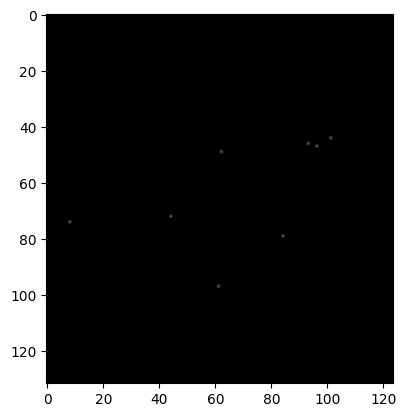

In [71]:
rgb = get_nbhd_rgb(nbhds=[30])
plt.imshow(rgb)

In [72]:
spore = mushroom.dtype_to_spore['xenium']

In [74]:
spore.learner_data.dtype_to_section_to_adata['xenium'].keys()

dict_keys(['HT206B1-U1', 'HT206B1-U8', 'HT206B1-U9', 'HT206B1-U16', 'HT206B1-U17', 'HT206B1-U24'])

In [75]:
a = spore.learner_data.dtype_to_section_to_adata['xenium']['HT206B1-U1']
a

AnnData object with n_obs × n_vars = 115764 × 377
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nbhd_xenium_level0', 'nbhd_integrated_level0', 'nbhd_multiplex_level0', 'nbhd_xenium_level1', 'nbhd_integrated_level1', 'nbhd_multiplex_level1', 'nbhd_xenium_level2', 'nbhd_integrated_level2', 'nbhd_multiplex_level2'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'ppm', 'spatial', 'log1p'
    obsm: 'spatial'

In [101]:
a.obs['cell_type_specific'] = a.obs['cell_type'].to_list()

In [86]:
meta = pd.read_csv(
    '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/auxiliary/xenium/HT206B1-H2L1Us1_17_cell_type.txt',
    sep='\t', index_col=0
)
a.obs = pd.merge(a.obs, meta, left_index=True, right_index=True, how='left')
a.obs

,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,nbhd_xenium_level0,nbhd_integrated_level0,nbhd_multiplex_level0,nbhd_xenium_level1,nbhd_integrated_level1,nbhd_multiplex_level1,nbhd_xenium_level2,nbhd_integrated_level2,nbhd_multiplex_level2,cell_type
cell_id,,,,,,,,,,,,,,,,,,,,
aaaaeefm-1,1352.328735,856.673035,76,0,0,0,0,76,242.895478,35.447658,nbhd 4,nbhd 9,nbhd 4,nbhd 14,nbhd 13,nbhd 16,nbhd 22,nbhd 20,nbhd 29,Nothing
aaaagokl-1,1441.802612,871.474121,30,0,0,0,0,30,704.798776,22.397501,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,Cancer cells
aaaaippd-1,1468.341553,860.412964,103,0,0,0,0,103,547.474395,48.452658,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,Cancer cells
aaaajeja-1,1411.193359,855.234680,57,0,0,0,0,57,537.630332,29.938595,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,Cancer cells
aaablpen-1,1449.760132,858.455505,24,0,0,0,0,24,182.792507,12.824375,nbhd 5,nbhd 9,nbhd 4,nbhd 15,nbhd 13,nbhd 16,nbhd 25,nbhd 20,nbhd 29,Cancer cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oikcfelo-1,4173.947266,2610.432129,75,0,0,0,0,75,163.691412,25.603595,nbhd 4,nbhd 2,nbhd 4,nbhd 14,nbhd 13,nbhd 13,nbhd 22,nbhd 20,nbhd 23,T-cells
oikcgcbk-1,4191.832520,2608.656738,73,0,0,0,0,73,122.734692,18.107657,nbhd 4,nbhd 2,nbhd 4,nbhd 14,nbhd 13,nbhd 13,nbhd 22,nbhd 20,nbhd 23,T-cells
oikdmjki-1,4163.305664,2615.778076,152,0,0,0,0,152,233.864227,29.893439,nbhd 4,nbhd 2,nbhd 4,nbhd 14,nbhd 13,nbhd 13,nbhd 22,nbhd 20,nbhd 23,Plasma cells


In [88]:
f = a[a.obs['cell_type']=='T-cells'].copy()
f

AnnData object with n_obs × n_vars = 25995 × 377
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nbhd_xenium_level0', 'nbhd_integrated_level0', 'nbhd_multiplex_level0', 'nbhd_xenium_level1', 'nbhd_integrated_level1', 'nbhd_multiplex_level1', 'nbhd_xenium_level2', 'nbhd_integrated_level2', 'nbhd_multiplex_level2', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'ppm', 'spatial', 'log1p'
    obsm: 'spatial'

In [90]:
sc.pp.pca(f)
sc.pp.neighbors(f)
sc.tl.umap(f)

In [91]:
sc.tl.leiden(f)

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


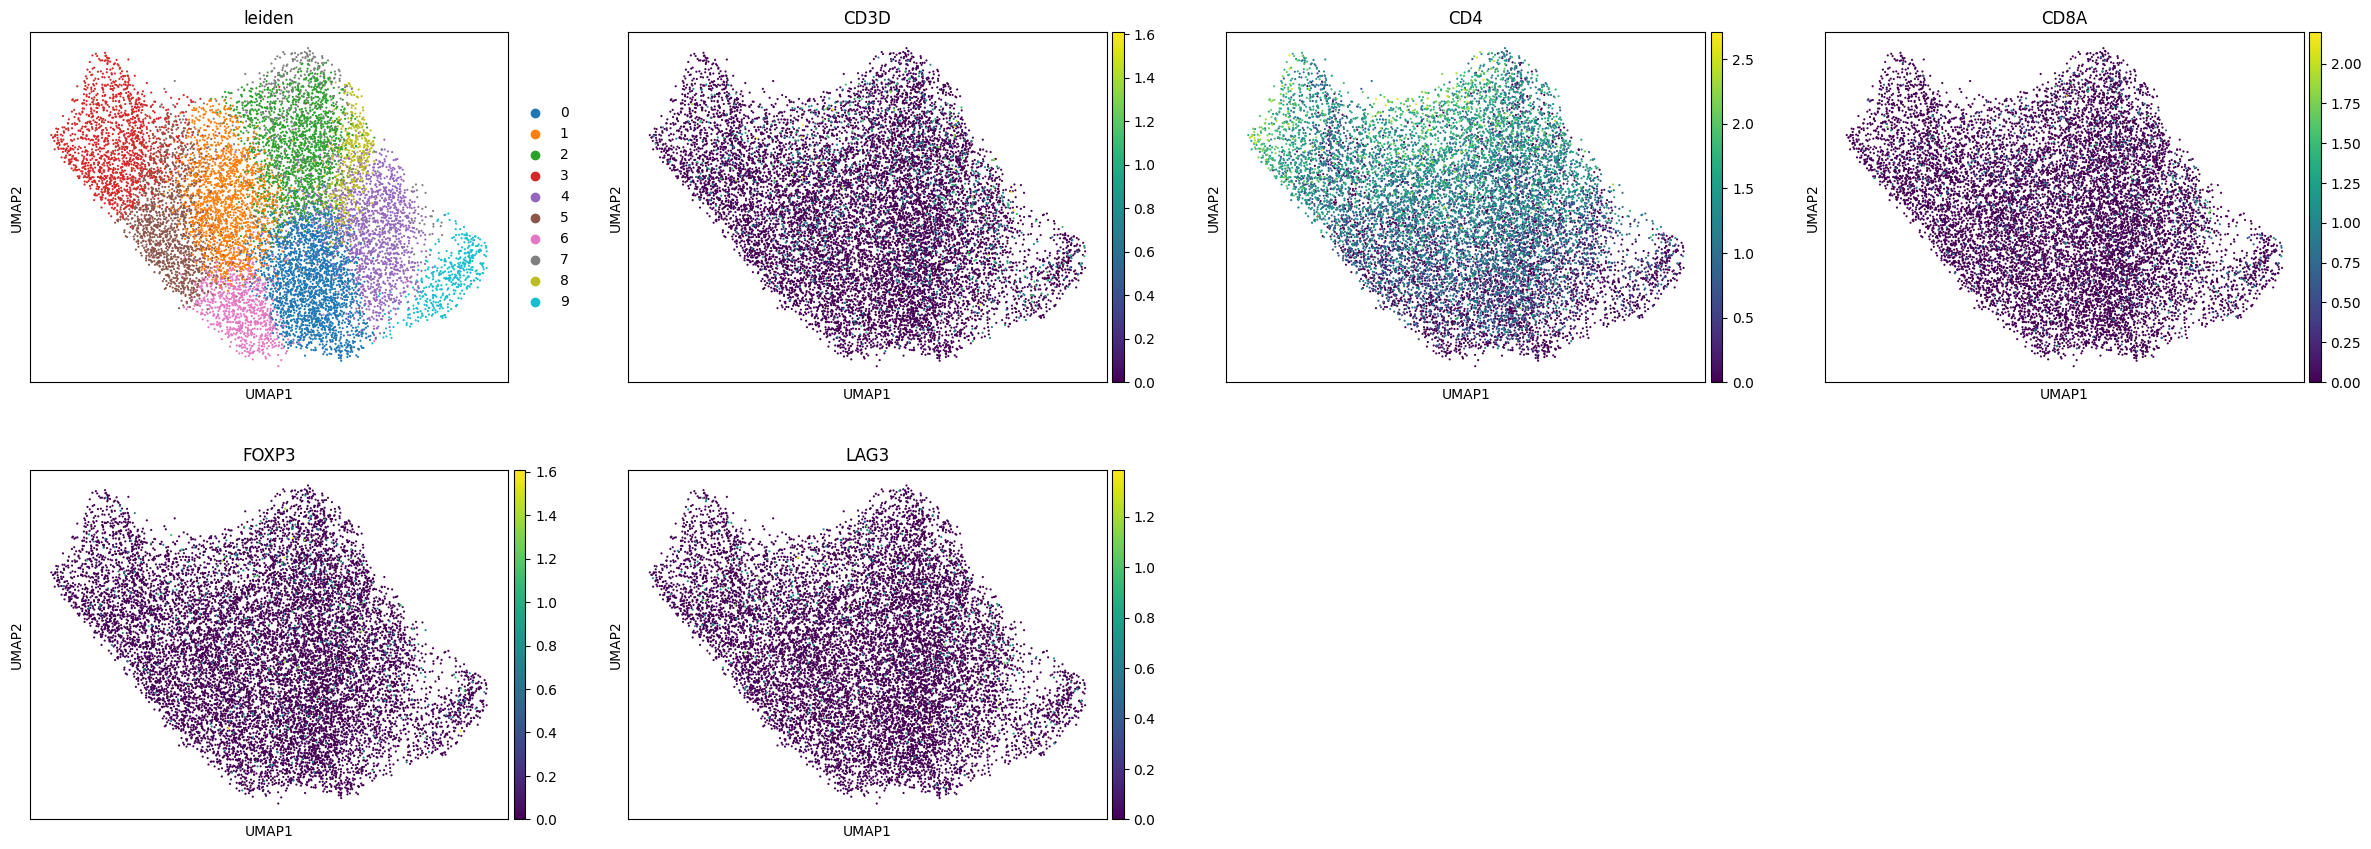

In [108]:
sc.pl.umap(f, color=['leiden', 'CD3D', 'CD4', 'CD8A', 'FOXP3'])

In [102]:
mapping = {
    'CD8 T cells': [2,3,4],
    'CD4 T cells': [0, 1, 6],
    'Treg': [5]
}
r_mapping = {v:k for k, vs in mapping.items() for v in vs}
f.obs['cell_type_specific'] = [r_mapping[int(x)] for x in f.obs['leiden'].to_list()]
barcode_to_specific = {k:v for k, v in zip(f.obs.index.to_list(), f.obs['cell_type_specific'])}

In [103]:
a.obs['cell_type_specific'] = [barcode_to_specific.get(x, ct)
                               for x, ct in zip(a.obs.index.to_list(), a.obs['cell_type_specific'].to_list())]

In [115]:
set(a.obs['cell_type_specific'])

{'Adipocytes',
 'B-cells',
 'CD4 T cells',
 'CD8 T cells',
 'Cancer cells',
 'Endothelial',
 'Fibroblasts',
 'Macrophages',
 'Mast cells',
 'Myoepitelial/Normal ducts',
 'NK cells',
 'Nothing',
 'Plasma cells',
 'Treg',
 'mregDC',
 nan,
 'pDC'}

##### cellchat

In [130]:
# make sure we get all genes and raw counts
adata = sc.read_h5ad('/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s0_HT206B1-U1_xenium.h5ad')
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


AnnData object with n_obs × n_vars = 115764 × 477
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'ppm', 'spatial', 'log1p'
    obsm: 'spatial'

In [132]:
adata.obs = pd.merge(adata.obs, a.obs[['cell_type_specific']], left_index=True, right_index=True, how='left')
adata = adata[~pd.isnull(adata.obs['cell_type_specific'])]
adata = adata[adata.obs['cell_type_specific']!='Nothing']
adata

View of AnnData object with n_obs × n_vars = 111732 × 477
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'cell_type_specific'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'ppm', 'spatial', 'log1p'
    obsm: 'spatial'

In [133]:
meta = adata.obs[['cell_type_specific']].copy()
meta['samples'] = 'sample'
meta.columns = ['cell_type', 'sample']
meta

,cell_type,sample
cell_id,,
aaaagokl-1,Cancer cells,sample
aaaaippd-1,Cancer cells,sample
aaaajeja-1,Cancer cells,sample
aaablpen-1,Cancer cells,sample
aaaclnhj-1,Cancer cells,sample
...,...,...
oikcfelo-1,CD4 T cells,sample
oikcgcbk-1,CD8 T cells,sample
oikdmjki-1,Plasma cells,sample


In [140]:
coordinates = pd.DataFrame(data=np.asarray(adata.obsm['spatial']), columns=['x', 'y'], index=meta.index.to_list())
coordinates.index.name = 'cell_id'
coordinates

,x,y
cell_id,,
aaaagokl-1,1441,871
aaaaippd-1,1468,860
aaaajeja-1,1411,855
aaablpen-1,1449,858
aaaclnhj-1,1441,844
...,...,...
oikcfelo-1,4173,2610
oikcgcbk-1,4191,2608
oikdmjki-1,4163,2615


In [143]:
exp = pd.DataFrame(data=adata.X.toarray(), columns=adata.var.index.to_list(), index=adata.obs.index.to_list())
exp.index.name = 'cell_id'
exp

,ABCC11,ACAN,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,ADGRE1,ADGRL4,...,UCHL1,UMOD,UPK3B,VCAN,VEGFA,VIM,VPREB1,VSIG4,VWA5A,VWF
cell_id,,,,,,,,,,,,,,,,,,,,,
aaaagokl-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,1.582409,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
aaaaippd-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,1.179402,0.000000,0.0,0.000000,0.0,0.0
aaaajeja-1,0.0,0.0,0.0,0.0,0.0,1.110240,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,1.110240,0.0,0.000000,0.0,0.0
aaablpen-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
aaaclnhj-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.938853,0.575784,...,0.0,0.0,0.000000,0.575784,2.080280,0.575784,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oikcfelo-1,0.0,0.0,0.0,0.0,0.0,1.729884,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,1.729884,0.0,0.000000,0.0,0.0
oikcgcbk-1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,2.495128,0.0,0.000000,0.0,0.0
oikdmjki-1,0.0,0.0,0.0,0.0,0.0,0.567106,0.567106,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,1.190728,0.000000,2.318251,0.0,0.000000,0.0,0.0


In [137]:
cellchat_dir = os.path.join(project_dir, case, 'cellchat', 'HT206B1-U1')
Path(cellchat_dir).mkdir(parents=True, exist_ok=True)

In [144]:
meta.to_csv(os.path.join(cellchat_dir, 'meta.txt'), sep='\t')
coordinates.to_csv(os.path.join(cellchat_dir, 'coordinates.txt'), sep='\t')
exp.to_csv(os.path.join(cellchat_dir, 'expression.txt'), sep='\t')
